In [30]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import urllib.request
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [31]:
#root_name = 'GaiaSource_003112-005263.csv'
#name = root_name + '.gz'
#fn = 'http://cdn.gea.esac.esa.int/Gaia/gedr3/gaia_source/'+name
#executable = 'wget --directory-prefix=data/GaiaSource/ '+fn
#os.system(executable)
#!wget -r -np -nH --show-progress --cut-dirs=3 -P data/GaiaSource http://cdn.gea.esac.esa.int/Gaia/gedr3/gaia_source
#!gzip -d data/GaiaSource/*

In [76]:
import pandas as pd
import glob
import os
#all_files = glob.glob('data/GaiaSource/*.csv')
all_files = [ 'processed.csv']
#all_files = [ 'data/GaiaSource/GaiaSource_052435-052636.csv']
data = pd.concat(map(pd.read_csv, all_files)) #('data/GaiaSource/'+root_name)

# Filter out parallax errors 
data = data[['ra', 'dec', 'phot_g_mean_mag', 'parallax', 'parallax_over_error', 'bp_rp', 'visibility_periods_used',
    'phot_g_mean_flux_over_error', 'phot_bp_mean_flux_over_error', 'phot_rp_mean_flux_over_error']]


In [77]:
data = data[np.abs(1000.0 / (data['parallax'])) < 500]
data = data[data['parallax_over_error'] > 10]
data = data[data['phot_g_mean_flux_over_error'] > 50]
data = data[data['phot_bp_mean_flux_over_error'] > 20]
data = data[data['phot_rp_mean_flux_over_error'] > 20]
data = data[data['visibility_periods_used'] > 10]
#data.to_csv('processed.csv')

In [78]:
import warnings
def to_abs_mag(mag, parallax, par_error):
    mag = np.array(mag)
    par = np.array(parallax)
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        distance = np.abs(1.0 / (par / 1000.0)) 
        absmag = mag + 5.0 - (5.0 * np.log10(distance))
        return absmag

# Magnitude
data['mag'] = to_abs_mag(data.phot_g_mean_mag, data.parallax, data.parallax_over_error)
data.dropna(subset=['mag'], inplace=True)

In [111]:

# Calculate colors
import utils
import importlib
importlib.reload(utils)
def index_to_temp(index):
    return 5601 / np.power(index + .3, 2.0/3.0)

temp = data.bp_rp.apply(index_to_temp)
data['color'] = temp.apply(utils.k_to_rgb)

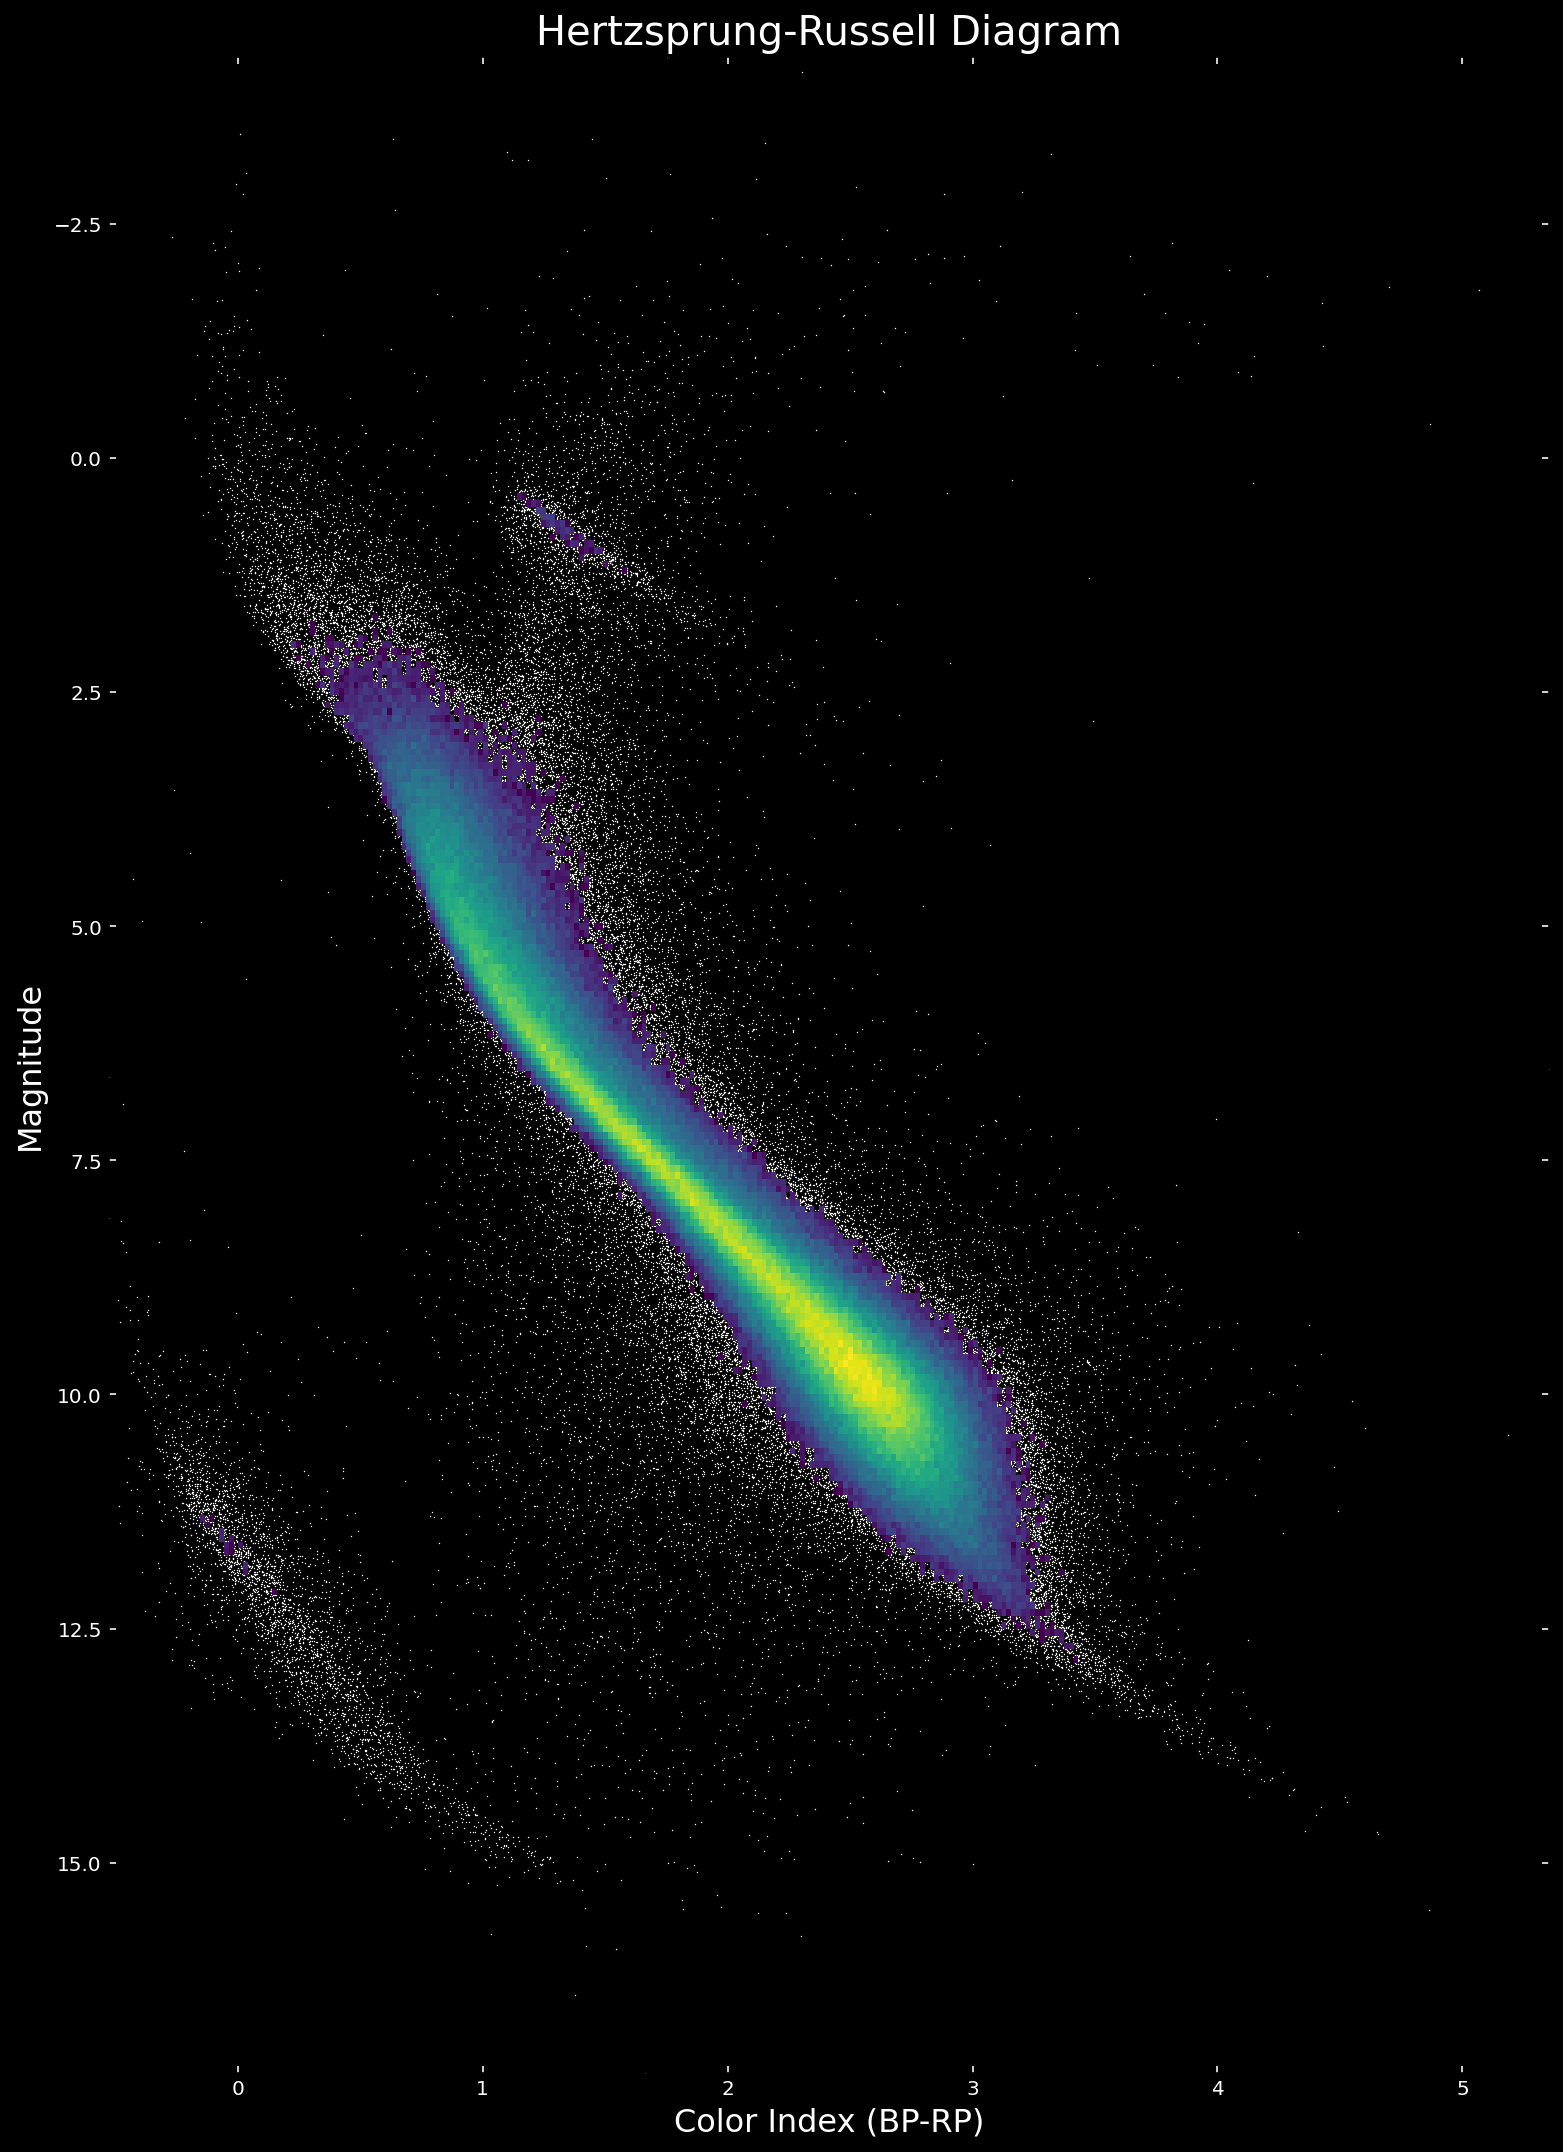

In [131]:
from matplotlib import colors
fig = plt.figure(
    figsize=(10, 14),
    facecolor='black'
    )
ax = fig.add_axes([1, 1, 1, 1])

ax.set_facecolor('black')
ax.set_title('Hertzsprung-Russell Diagram', color='white', fontsize=20)
ax.set_xlabel('Color Index (BP-RP)', color='white', fontsize=16)
ax.set_ylabel('Magnitude', color='white', fontsize=16)
ax.tick_params(top='off', right='off', direction='in', colors='white')
h = ax.hist2d(data.bp_rp, data.mag, bins=300, cmin=10, norm=colors.PowerNorm(0.5), zorder=0.5)
ax.scatter( data.bp_rp, data.mag,
    marker='.',
    s=2.0,
    alpha=1.0,
    zorder=0,
    color='w',
    linewidth=0)
ax.invert_yaxis()

#plt.savefig("Hertzsprung-Russell_Gaia.png", facecolor='white', edgecolor='black')

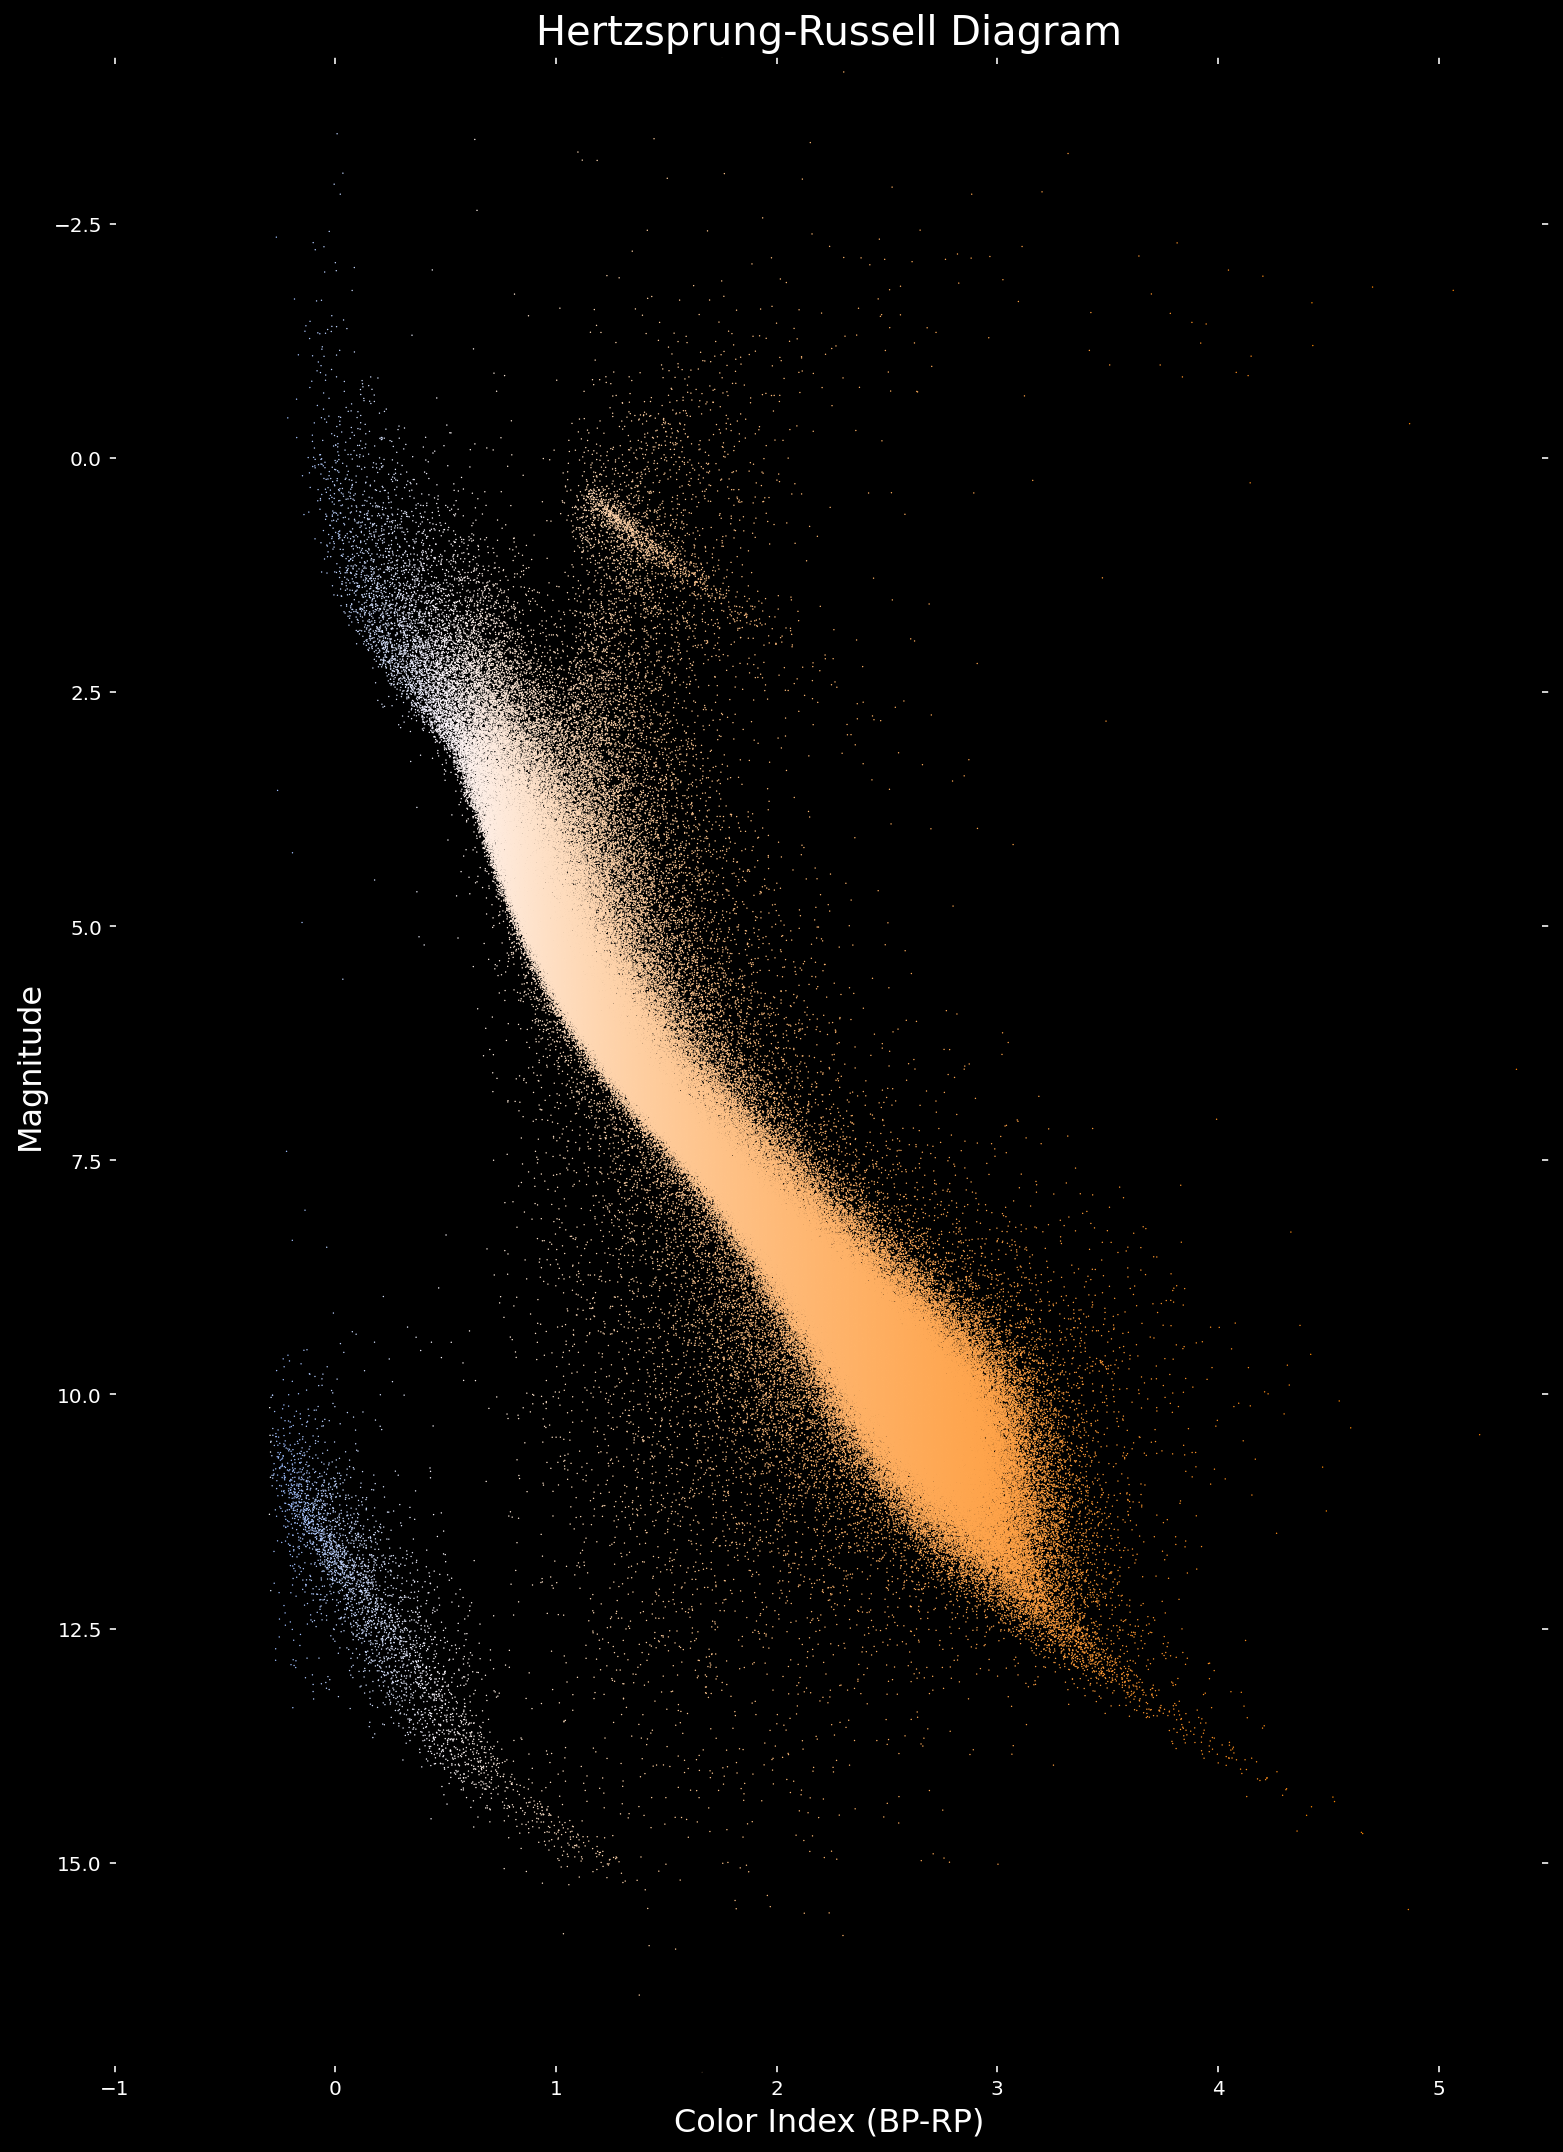

In [133]:
fig = plt.figure(
    figsize=(10, 14),
    facecolor='black'
    )
ax = fig.add_axes([1, 1, 1, 1])

ax.set_facecolor('black')
ax.set_title('Hertzsprung-Russell Diagram', color='white', fontsize=20)
ax.set_xlabel('Color Index (BP-RP)', color='white', fontsize=16)
ax.set_ylabel('Magnitude', color='white', fontsize=16)
ax.set_xlim(min(data.bp_rp) - .5, 5.5)#max(data.bp_rp))
ax.set_ylim(min(data.mag), max(data.mag))
ax.tick_params(top='off', right='off', direction='in', colors='white')
ax.scatter( data.bp_rp, data.mag,
    marker='.',
    s=2.0,
    alpha=1.0,
    zorder=0,
    facecolors=data['color'],
    color='w',
    linewidth=0)
ax.invert_yaxis()